In [163]:
import scipy.io
import pandas as pd
from datetime import datetime
import numpy as np
from scipy import signal
from IPython.display import display, HTML
import pandas as pd
import numpy as np   
import matplotlib.pyplot as plt  
from matplotlib import cm   
from statsmodels.graphics.gofplots import qqplot 
from scipy.signal import stft
from scipy import signal 
from scipy.fftpack import fft, fftfreq 
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.mlab as mlab 
import math
import os
from scipy.stats import norm, kurtosis,skew 
mat = []
path = '../WindTurbineHighSpeedBearingPrognosis-Data'
for file in os.listdir(path):
    if file.endswith('.mat'):
        date_time_obj = datetime.strptime(file[5:len(file)-4], '%Y%m%dT%H%M%SZ')
        my_dictionary = {
        "Date": None,
        "File": [], 
        }
        print(f'{path}/{file} - data {date_time_obj}')
        my_dictionary["Date"]=date_time_obj
        my_dictionary["File"]=scipy.io.loadmat(f'{path}/{file}')
        mat.append(my_dictionary)



../WindTurbineHighSpeedBearingPrognosis-Data/data-20130307T015746Z.mat - data 2013-03-07 01:57:46
../WindTurbineHighSpeedBearingPrognosis-Data/data-20130308T023421Z.mat - data 2013-03-08 02:34:21
../WindTurbineHighSpeedBearingPrognosis-Data/data-20130309T023343Z.mat - data 2013-03-09 02:33:43
../WindTurbineHighSpeedBearingPrognosis-Data/data-20130310T030102Z.mat - data 2013-03-10 03:01:02
../WindTurbineHighSpeedBearingPrognosis-Data/data-20130311T030024Z.mat - data 2013-03-11 03:00:24
../WindTurbineHighSpeedBearingPrognosis-Data/data-20130312T061710Z.mat - data 2013-03-12 06:17:10
../WindTurbineHighSpeedBearingPrognosis-Data/data-20130313T063404Z.mat - data 2013-03-13 06:34:04
../WindTurbineHighSpeedBearingPrognosis-Data/data-20130314T065041Z.mat - data 2013-03-14 06:50:41
../WindTurbineHighSpeedBearingPrognosis-Data/data-20130315T065003Z.mat - data 2013-03-15 06:50:03
../WindTurbineHighSpeedBearingPrognosis-Data/data-20130316T065643Z.mat - data 2013-03-16 06:56:43
../WindTurbineHighSp

In [191]:
from scipy import special
def calculate_kurtosis(Sxx,fs,f,windowSize,confidenceLevel):
    M4=[]
    M2 = []
    for value in Sxx:
        M4.append(np.mean(np.power(value, 2)))   
        M2.append(np.mean(value))   
    
    K = len(Sxx[0]) 
    SK=[] 
    if K<2:
        for index in range(len(M4)):
            SK.append(M4[index]/np.power(M2[index],2) - 2) 
        
    else:
        for index in range(len(M4)):
            SK.append((K+1)/(K-1)*M4[index]/np.power(M2[index],2) - 2)

    for index in range(len(SK)):
        if f[index]<= (fs/windowSize):
            SK[index]=0
        elif f[index]>= (fs/2-fs/windowSize):
            SK[index]=0
            
    alpha = 1 - confidenceLevel
    threshold = -np.sqrt(2)*special.erfcinv(2*(1-alpha/2))*2/np.sqrt(K)
    return SK,threshold

In [192]:
confidenceLevel=0.950  
window = window = signal.windows.kaiser(240, beta=20)
pad_to=1024
var=0
Fs=97656
time = [0.0006144015728680265 for i in range(585936)]
length_windows=(int(pad_to/2)+1)
kurtosis_threeshold=pd.DataFrame(np.zeros((length_windows*50,2)),columns=['SpectralKurtosis','Threshold'])
for i in range(50):   
    Sxx ,f, t= mlab.specgram(x=mat[i]["File"]['vibration'].flatten(), Fs=Fs ,NFFT=240, window = window, noverlap=150, mode='psd' ,pad_to=pad_to)     
    SK, threshold = calculate_kurtosis(Sxx,Fs,f,128,confidenceLevel) 
    kurtosis_threeshold.loc[var:var+len(SK)-1,'SpectralKurtosis'] = SK
    kurtosis_threeshold.loc[var:var+len(SK)-1,'Frequenze'] =f 
    var = len(SK)*(i+1 if i>0 else 1) 

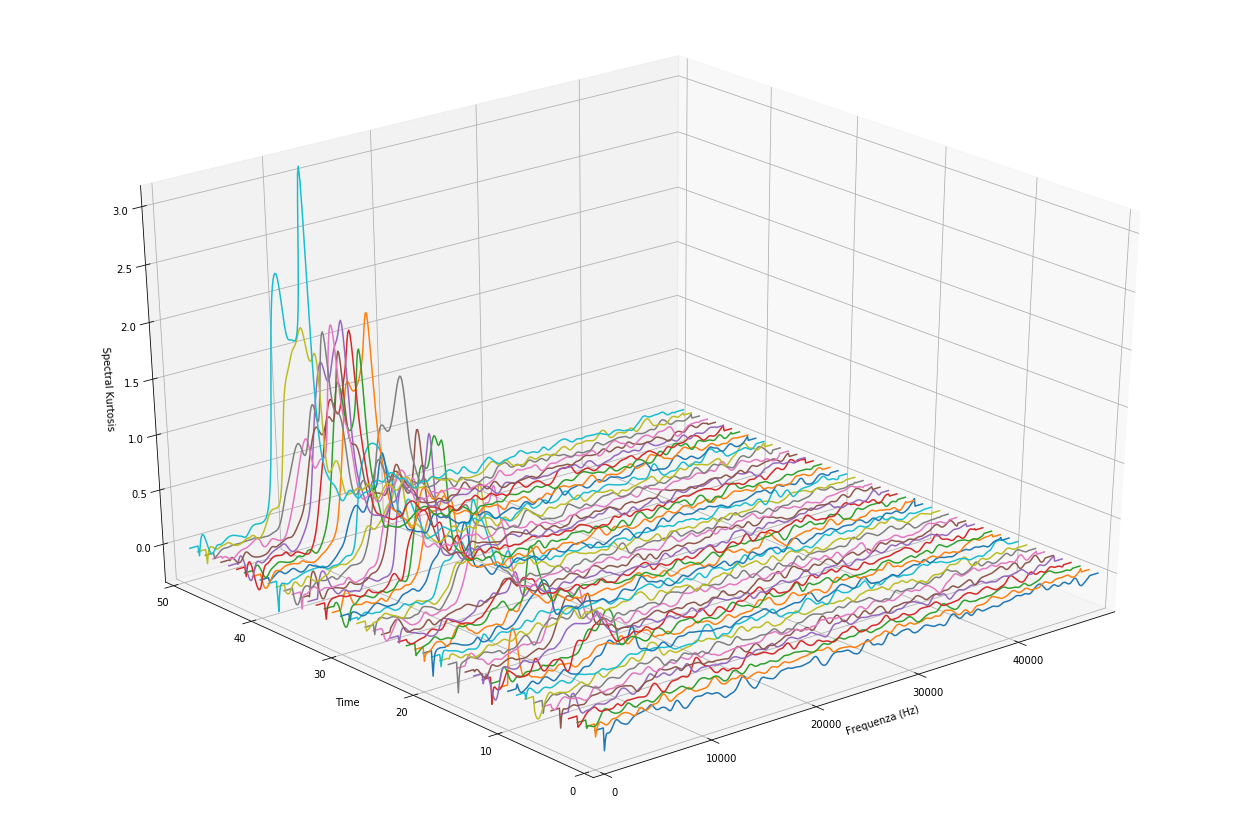

In [209]:
plt.rcParams["figure.figsize"] =(22,15)
fig = plt.figure()
ax = fig.gca(projection='3d')
graph_day = 50
ax.set_xlim3d(math.ceil(Fs/2),0) 
ax.set_ylim3d(graph_day, 0)   
var=0  
for i in range(graph_day):    
    day = [i for da in range(length_windows)]
    ax.plot(kurtosis_threeshold.loc[var:var+len(day)-1,'Frequenze'], day, kurtosis_threeshold.loc[var:var+len(day)-1,'SpectralKurtosis'])   
    var = len(day)*(i+1 if i>0 else 1)  

ax.view_init(30, 50)
ax.set_xlabel("Frequenza (Hz)")
ax.set_ylabel("Time")
ax.set_zlabel("Spectral Kurtosis")  
plt.show()

In [210]:
 
N = 50*Fs*6#length of the array 
T = 1/Fs;

time = [0.0006144015728680265*(day+1) for day in range(50) for i in range(585936)]
print("# Samples:",N)
w = np.int(np.floor(Fs*6)); #width of the window for computing RMS
steps =  np.int_(np.floor(N/w)); #Number of steps for RMS
t_RMS = np.zeros((steps,1)); #Create array for RMS time values
x_RMS = np.zeros((steps,1)); #Create array for RMS values  
for i in range (0, steps):
    t_RMS[i] = np.mean(time[(i*w):((i+1)*w)])
    x_RMS[i] = np.sqrt(np.mean(mat[i]["File"]['vibration'].flatten()**2))   
x_RMS = x_RMS.flatten()

# Samples: 29296800


In [211]:
dataframe_serie = pd.DataFrame(columns=["Time", "Mean", "Std", "Skewness", "Kurtosis", "Peak2Peak",
    "RMS", "CrestFactor", "ShapeFactor", "ImpulseFactor", "MarginFactor", "Energy",
    "SKMean", "SKStd", "SKSkewness", "SKKurtosis"])
var=0   
for x in range(50):
    vibration = mat[x]["File"]['vibration'].flatten()
    SK = kurtosis_threeshold.loc[var:var+length_windows-1,'SpectralKurtosis'].values
    dataframe_serie.loc[x,'Time']=mat[x]['Date']
    dataframe_serie.loc[x,'Mean']=vibration.mean()
    dataframe_serie.loc[x,'Std']=vibration.std()
    dataframe_serie.loc[x,'Skewness']=skew(vibration)
    dataframe_serie.loc[x,'Kurtosis']=kurtosis(vibration)
    dataframe_serie.loc[x,'Peak2Peak']=np.ptp(vibration)
    dataframe_serie.loc[x,'RMS']=x_RMS[x]
    dataframe_serie.loc[x,'CrestFactor']=np.max(vibration)/x_RMS[x]
    dataframe_serie.loc[x,'ShapeFactor']=x_RMS[x]/np.mean(np.abs(vibration))
    dataframe_serie.loc[x,'ImpulseFactor']=np.max(vibration)/np.mean(np.abs(vibration))
    dataframe_serie.loc[x,'MarginFactor']=np.max(vibration)/np.power(np.mean(np.abs(vibration)),2)
    dataframe_serie.loc[x,'Energy']=np.sum(np.power(vibration,2))
    dataframe_serie.loc[x,'SKMean']=SK.mean()
    dataframe_serie.loc[x,'SKStd']=SK.std()
    dataframe_serie.loc[x,'SKSkewness']=skew(SK)
    dataframe_serie.loc[x,'SKKurtosis']=kurtosis(SK)
    var = length_windows*(x+1 if x>0 else 1) 


In [212]:
from statsmodels.sandbox.tsa.movstat import movmean 

dataframe_without_noise = movmean(dataframe_serie.iloc[:,1:].values,5,lag='centered') 

slice(6, -6, None)
(58, 15)
(5, 1)


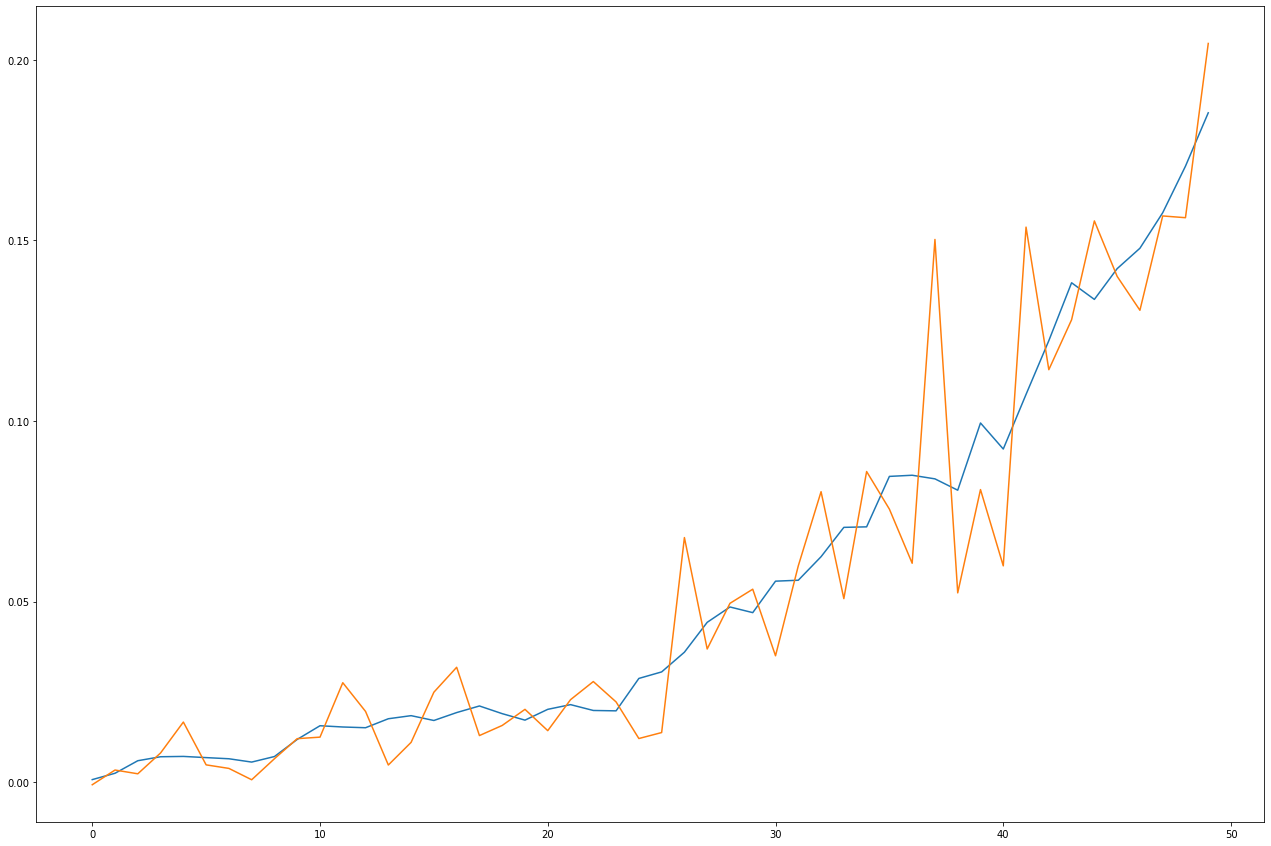

In [213]:
plt.plot(dataframe_without_noise[:,11])
plt.plot(dataframe_serie.SKMean.values)

In [214]:
pearson_matrix = pd.DataFrame(dataframe_without_noise,columns=dataframe_serie.columns[1:]).astype(float).corr(method="pearson")
for value in range(len(pearson_matrix.index)):
        for val in range(len(pearson_matrix.columns)):
            pearson_matrix.iloc[value,val]=f'{pearson_matrix.iloc[value,val]:f}' 
               
pearson_matrix=pearson_matrix.astype(float)
display(pearson_matrix)

,Mean,Std,Skewness,Kurtosis,Peak2Peak,RMS,CrestFactor,ShapeFactor,ImpulseFactor,MarginFactor,Energy,SKMean,SKStd,SKSkewness,SKKurtosis
Mean,1.000000,-0.172245,0.203078,-0.476684,-0.363962,-0.158102,-0.482788,-0.461127,-0.482498,-0.704573,-0.146975,-0.544765,-0.539133,-0.492574,-0.410065
Std,-0.172245,1.000000,0.571627,0.899717,0.957939,0.999895,0.852456,0.919148,0.869161,0.459479,0.997550,0.877507,0.880714,0.634988,0.491404
Skewness,0.203078,0.571627,1.000000,0.432200,0.433840,0.575357,0.278111,0.436552,0.306666,-0.077647,0.608606,0.377324,0.385094,0.063479,-0.012004
Kurtosis,-0.476684,0.899717,0.432200,1.000000,0.964943,0.895334,0.935164,0.997041,0.952465,0.728888,0.891615,0.989191,0.993852,0.681555,0.495691
Peak2Peak,-0.363962,0.957939,0.433840,0.964943,1.000000,0.955134,0.962777,0.972685,0.972267,0.691430,0.945238,0.945095,0.954604,0.746376,0.572335
RMS,-0.158102,0.999895,0.575357,0.895334,0.955134,1.000000,0.847811,0.914976,0.864562,0.450913,0.997751,0.872103,0.875395,0.629275,0.486477
CrestFactor,-0.482788,0.852456,0.278111,0.935164,0.962777,0.847811,1.000000,0.931431,0.998588,0.851614,0.827666,0.915289,0.934141,0.817213,0.644810
ShapeFactor,-0.461127,0.919148,0.436552,0.997041,0.972685,0.914976,0.931431,1.000000,0.949234,0.703248,0.911798,0.990606,0.992233,0.695813,0.509180
ImpulseFactor,-0.482498,0.869161,0.306666,0.952465,0.972267,0.864562,0.998588,0.949234,1.000000,0.837502,0.846913,0.933545,0.950378,0.804065,0.628500
MarginFactor,-0.704573,0.459479,-0.077647,0.728888,0.691430,0.450913,0.851614,0.703248,0.837502,1.000000,0.423336,0.725035,0.749260,0.750657,0.590029


In [215]:
def calculus_monoticity(x):
    return np.abs(np.sum(np.sign(np.diff(x))))/(len(x)-1)

In [216]:
values_feature=[]
for i in range(dataframe_without_noise.shape[1]): 
    values_feature.append(calculus_monoticity(dataframe_without_noise[:,i]))
 

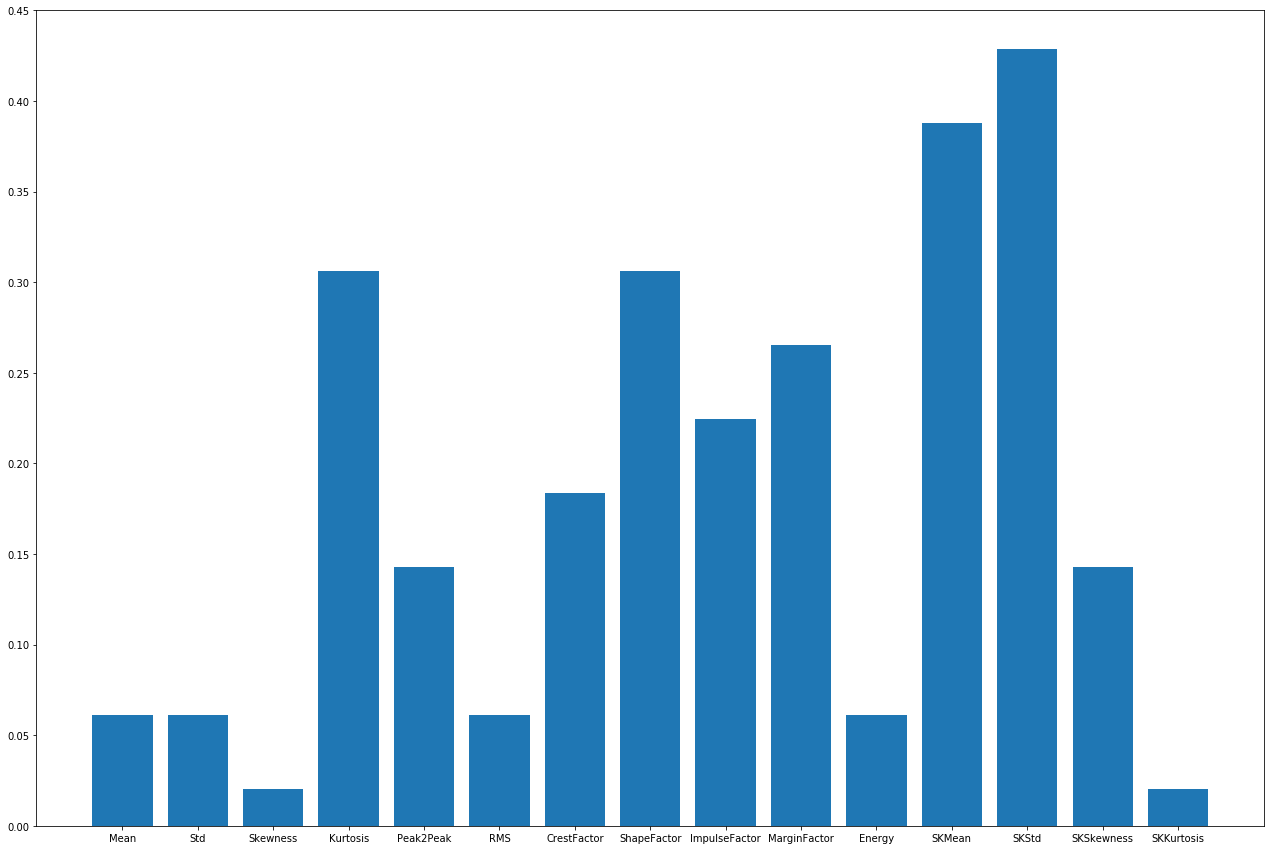

In [217]:

plt.bar([i for i in dataframe_serie.columns[1:]], values_feature)
plt.show()

In [238]:
features_final=[]
for values in range(len(values_feature)):
    if values_feature[values]>0.3:
        features_final.append(dataframe_without_noise[:,values].copy())

features_final=np.array(features_final).T
features_final.shape

(50, 4)

In [239]:
from sklearn import preprocessing
x_train_standarized = preprocessing.Normalizer().fit(features_final).transform(features_final)
#--------------------------------------SELECT ALL FEATURES------------------------------------------------------------
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(x_train_standarized)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

Text(0.5, 0.98, 'PCA information')

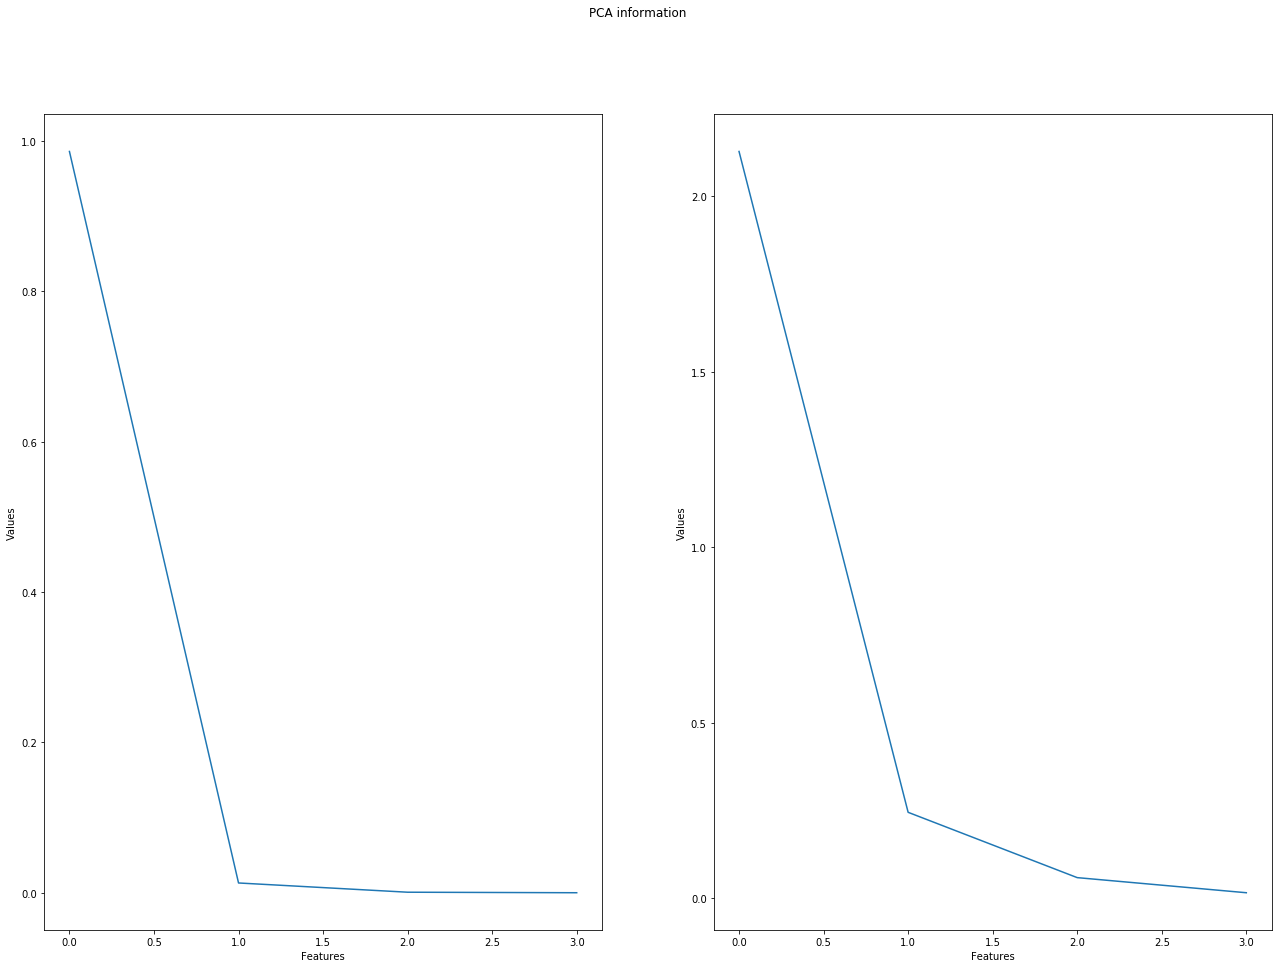

In [240]:
plt.rcParams["figure.figsize"] =(15,8)
values=pca.explained_variance_ratio_ 
fig = plt.figure(figsize=(22, 15))
i=1  
fig.add_subplot(1,2,1) 
plt.plot(pca.explained_variance_ratio_)

plt.ylabel("Values") 
plt.xlabel("Features") 

fig.add_subplot(1,2,2) 
plt.plot(pca.singular_values_)
plt.ylabel("Values") 
plt.xlabel("Features") 

plt.suptitle('PCA information')


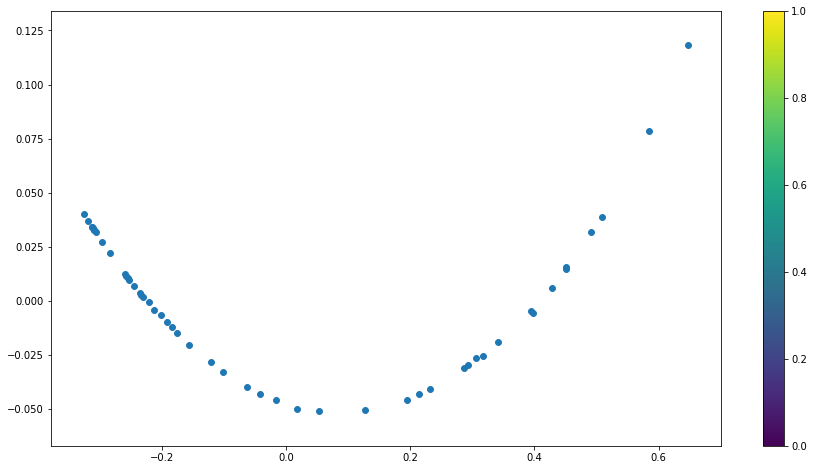

In [241]:

pca = PCA(n_components=2)
pca.fit(x_train_standarized)
array_decomposition=pca.transform(x_train_standarized)
fig, ax = plt.subplots()
im = ax.scatter(array_decomposition[:,0],array_decomposition[:,1],vmin=0, vmax=20, s=35, cmap=cm)

# Add a colorbar
fig.colorbar(im, ax=ax) 
 
plt.show()

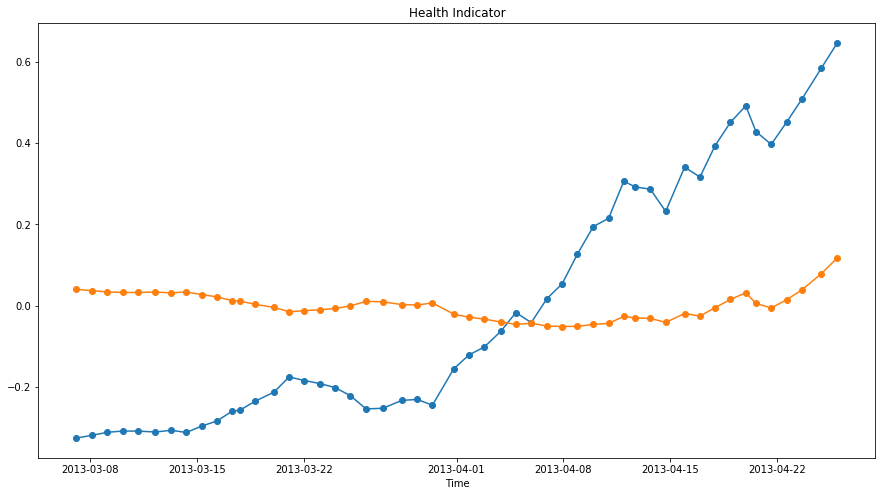

In [242]:
plt.plot(dataframe_serie.Time.values, array_decomposition[:,], '-o')
plt.xlabel('Time')
plt.title('Health Indicator')
 
plt.show()

In [ ]:
features_final